In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, ExpSquaredKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
#import warnings
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

## Section 1: including and visualizing 13 TeV dataset

In [14]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("savedOutputs/xvalO.npy")
yvalO = np.load("savedOutputs/yvalO.npy")
xerrO = np.load("savedOutputs/xerrO.npy")
xlowO = np.load("savedOutputs/xlowO.npy")

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("savedOutputs/xval.npy")
yval = np.load("savedOutputs/yval.npy")
xerr = np.load("savedOutputs/xerr.npy")

#10000 toys - created from 5 parameter fit to data with Poisson noise
toyList = np.load("savedOutputs/toyList.npy")
fixedHyperparams = np.load("savedOutputs/fixedHyperparams.npy")

sigToys = np.load("savedOutputs/signalToys_high.npy")
sigToysO = np.load("savedOutputs/signalToysO_high.npy")
standardParamSets = [(2500,2000,250), (1000, 2500, 250), (400, 3000, 250), (200, 3500, 250), (100, 4000, 250), 
             (75, 4500, 250), (50, 5000, 250), (40,5500, 250), (30, 6000,250)]

'''
sigToys = np.load("savedOutputs/signalToys.npy")
sigToysO = np.load("savedOutputs/signalToysO.npy")
standardParamSets = [(2000,2000,250), (700, 2500, 250), (250, 3000, 250), (125, 3500, 250), (70, 4000, 250), 
             (40, 4500, 250), (25, 5000, 250), (15,5500, 250), (10, 6000,250)]
'''


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


'\nsigToys = np.load("savedOutputs/signalToys.npy")\nsigToysO = np.load("savedOutputs/signalToysO.npy")\nstandardParamSets = [(2000,2000,250), (700, 2500, 250), (250, 3000, 250), (125, 3500, 250), (70, 4000, 250), \n             (40, 4500, 250), (25, 5000, 250), (15,5500, 250), (10, 6000,250)]\n'

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

In [5]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  #1./(t/sqrts)

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### This set has all bins that equal 0 removed. These 0 points really bias the GP

## GP SIGNAL FIGURE 8

In [29]:
def makePrettyPlots_sb(xs_long, xs_short, ys_long, ys_short, yd_short, bkgs, bkgsigs,xlow_short, title, ymax = 2e5):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs_long, ys_long, marker='o', ls='None', yerr = np.sqrt(ys_long), c='black', markersize=10, label="data+signal")
    bkg1Plot, = ax1.plot(xs_short, bkgs, color='g', linewidth=3.0, label="bkg only")
    bkg2Plot, = ax1.plot(xs_long, bkgsigs, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_short, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow_short,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    #print h1[:]
    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+signal vs bkg",(4520,3.5), fontsize=15)

    #ax2.set_ylim([-2, 8])

    zvals_2, chi2_2 = calcSignificance(ys_long, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(list(xlowO),markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+sig vs bkg+sig",(4520,3.5), fontsize=15)
    
    print len(yd_short), len(bkgs)
    zvals_3, chi2_3 = calcSignificance(yd_short, bkgs)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow_short,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(4520,3.5), fontsize=15)

    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="injected signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="signal fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(list(xlowO),markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [8]:
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

In [9]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    #while not passedFit and numRetries < 5:

    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
        '''
        if fit[0]['is_valid']: 
            passedFit=True
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1 
        '''

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

parameters (2500, 2000, 250)
0
A, mass, tau 21045.9735773 2057.37122462 207.642246309
chi2 bkg+signal mu=0 198.022017827
chi2 bkg+signal 141.293252438
73 73
chi2 bkg+signal 141.284725067


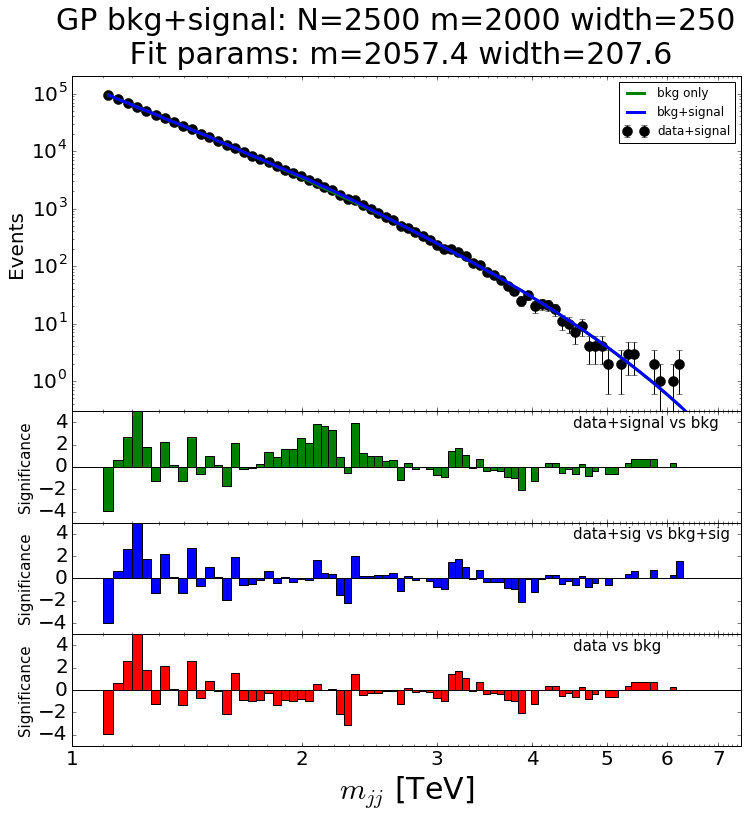

chi2 1282.65388327


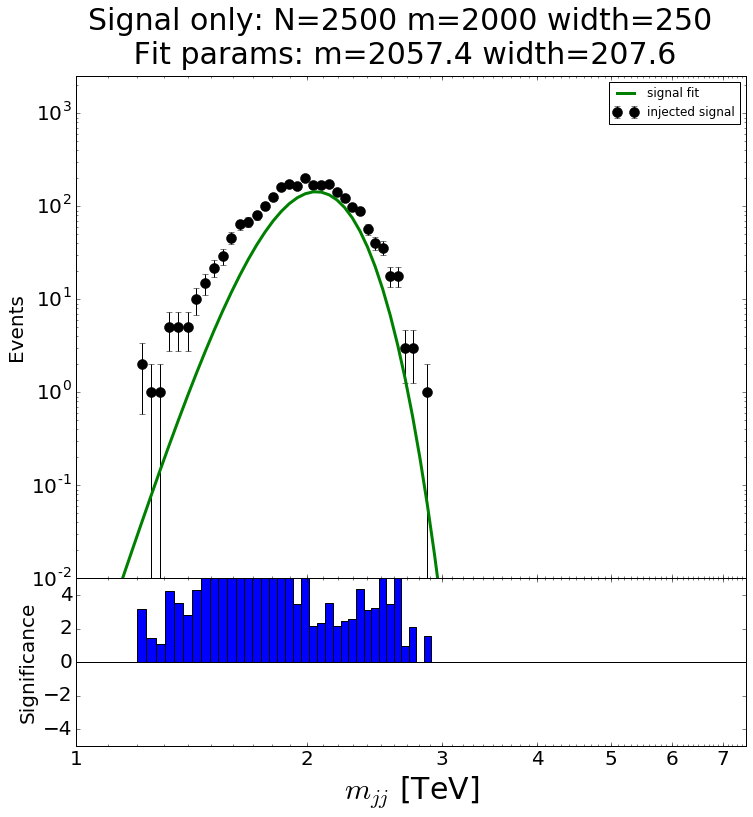

A, mass, tau 28941.8024111 2056.46868746 176.10126211
A, mass, tau 20525.6890259 2038.47783951 195.524518738
A, mass, tau 24378.2841292 2104.62986149 202.899406675
A, mass, tau 32689.0884103 2070.45496848 153.615205972
A, mass, tau 29057.104258 2102.19851284 159.275137538
A, mass, tau 15145.3085742 2090.30263337 251.464037568
A, mass, tau 21981.1013996 2080.78196225 142.202459993
A, mass, tau 28495.5436601 2118.84966491 156.254952407
A, mass, tau 25177.0664903 2084.42275994 217.792316377
parameters (1000, 2500, 250)
0
A, mass, tau 6073.0694931 2574.02233599 222.650202062
chi2 bkg+signal mu=0 200.581238839
chi2 bkg+signal 147.591209339
73 73
chi2 bkg+signal 141.284725065


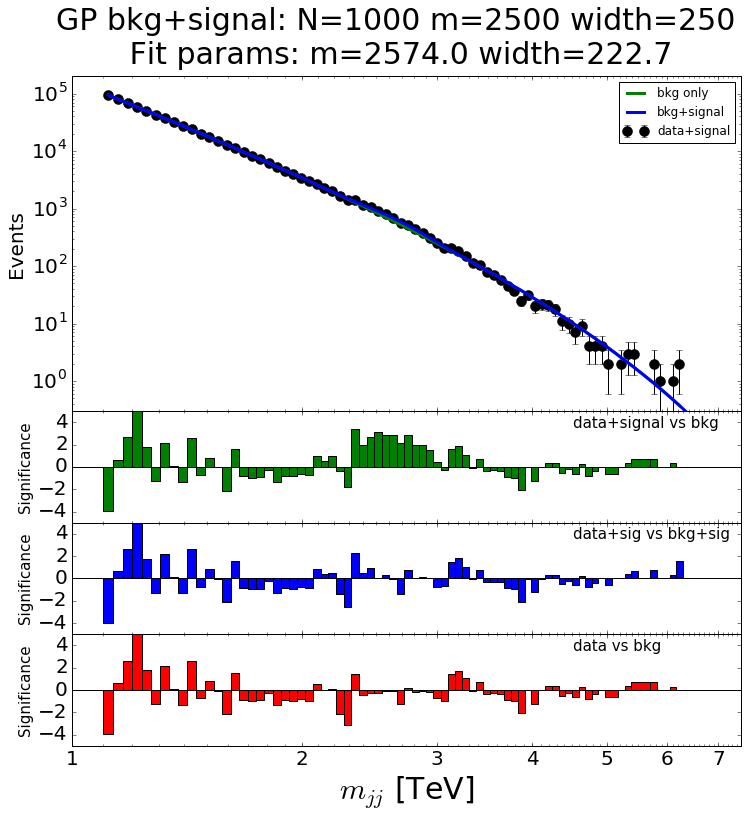

chi2 315.298768331


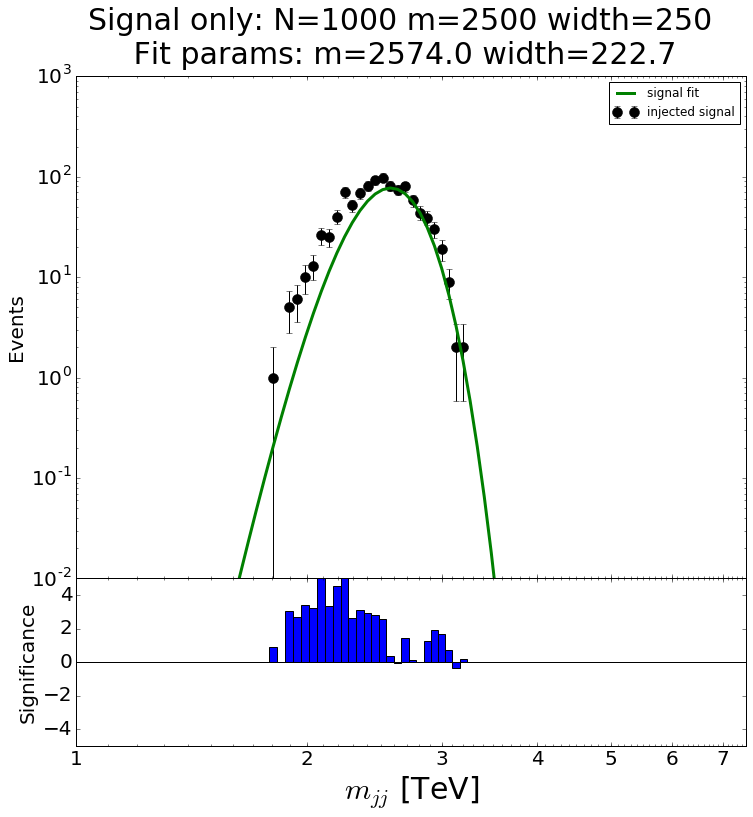

A, mass, tau 2846.55081522 2622.07434627 220.824104746
A, mass, tau 4645.70803307 2596.94742865 184.145674501
A, mass, tau 5996.58130809 2534.29024103 241.43739145
A, mass, tau 7168.17234082 2591.54911664 161.037325663
A, mass, tau 3866.79558261 2601.95890415 243.663911225
A, mass, tau 8543.53572294 2588.66061315 197.355597062
A, mass, tau 5206.43335154 2626.90944662 201.879219131
A, mass, tau 5951.99374616 2557.87865761 237.246986139
A, mass, tau 6757.83012711 2488.16465423 217.37424749
parameters (400, 3000, 250)
0
A, mass, tau 2108.86092522 3093.37782068 201.497126925
chi2 bkg+signal mu=0 196.412196756
chi2 bkg+signal 144.508137561
73 73
chi2 bkg+signal 141.284725065


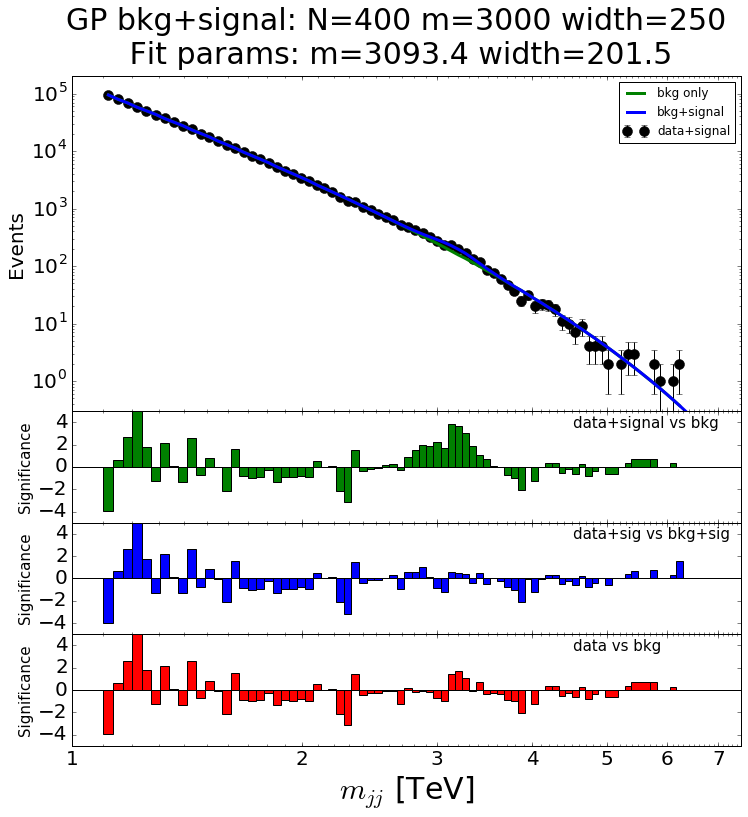

chi2 292.17620737


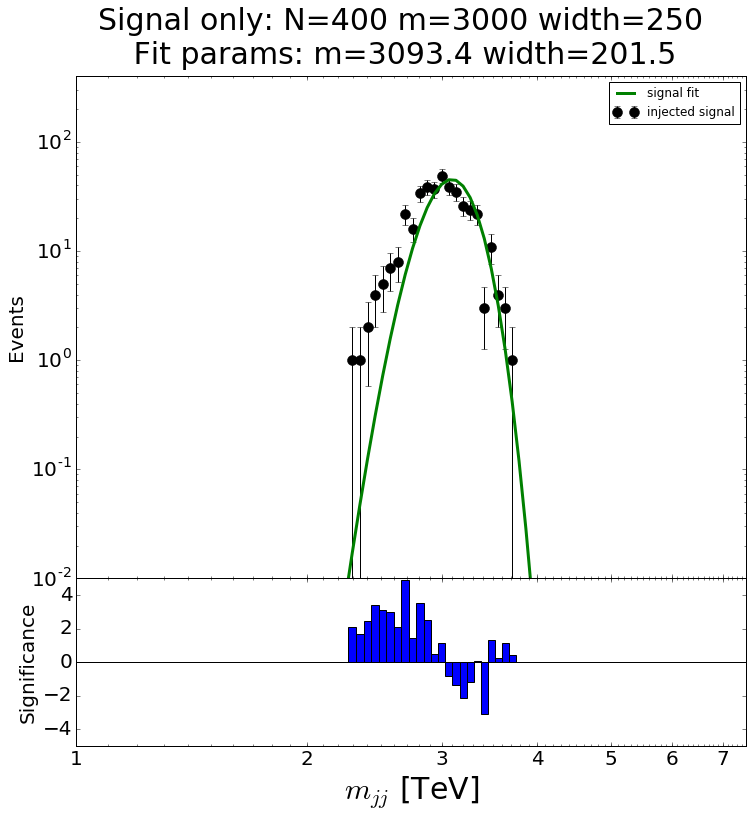

A, mass, tau 1407.12866481 3100.44562954 251.263223087
A, mass, tau 1573.14287325 3010.20967908 163.390458051
A, mass, tau 3645.04798481 3061.8255156 112.804926383
A, mass, tau 1378.98217641 3165.81933485 174.665599232
A, mass, tau 1738.64504011 3023.33818771 203.166537463
A, mass, tau 1594.33560826 3025.37887826 288.431301949
A, mass, tau 1998.9590972 3073.94455319 204.280706214
A, mass, tau 1545.51489724 3062.83761135 259.37884642
A, mass, tau 661.23634369 3067.12223073 282.132164849
parameters (200, 3500, 250)
0
A, mass, tau 772.805028895 3393.30080873 209.492966973
chi2 bkg+signal mu=0 178.628351597
chi2 bkg+signal 138.808071576
73 73
chi2 bkg+signal 141.284725065


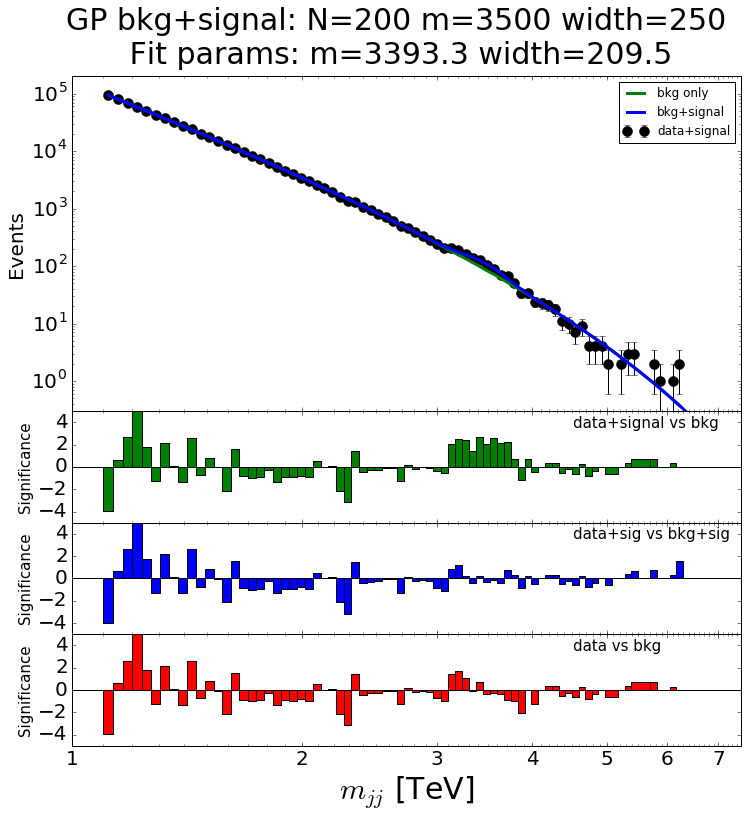

chi2 144.609353315


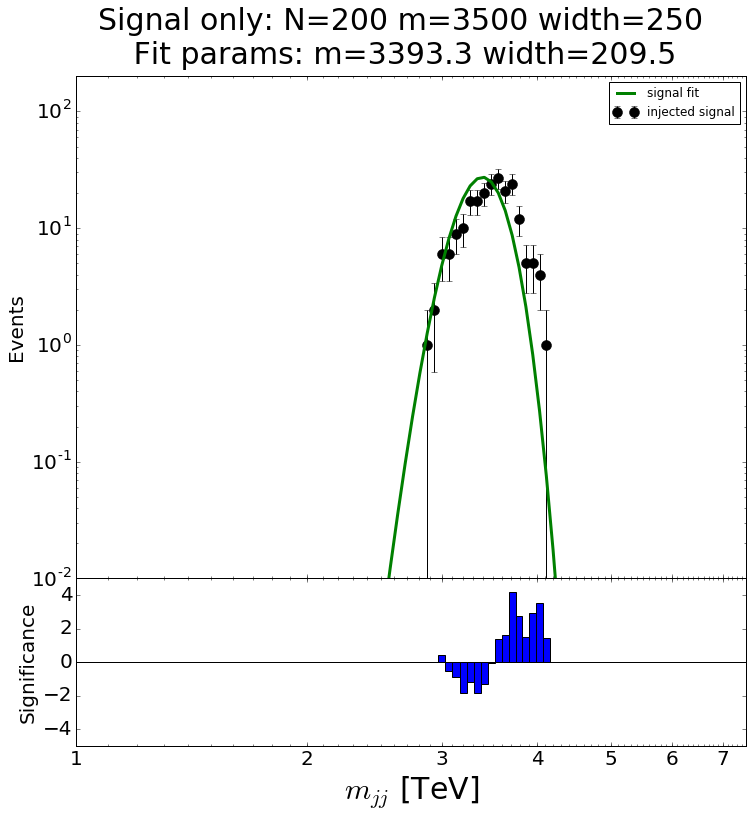

A, mass, tau 863.553099531 3546.38909609 231.325157371
A, mass, tau 487.073413067 3583.4076254 211.927120092
A, mass, tau 334.058509113 3518.13541716 271.551966901
A, mass, tau 468.031947605 3568.25901138 264.228624498
A, mass, tau 443.030565341 3565.35812454 311.218529417
A, mass, tau 824.936712777 3531.51400898 230.038314463
A, mass, tau 992.596366954 3636.57992986 166.215170106
A, mass, tau 891.11100379 3551.32055104 224.980932109
A, mass, tau 664.67562296 3629.78081374 233.14199202
parameters (100, 4000, 250)
0
A, mass, tau 170.409332697 4094.60787738 167.301822428
chi2 bkg+signal mu=0 160.985882817
chi2 bkg+signal 142.901402872
73 73
chi2 bkg+signal 141.284725065


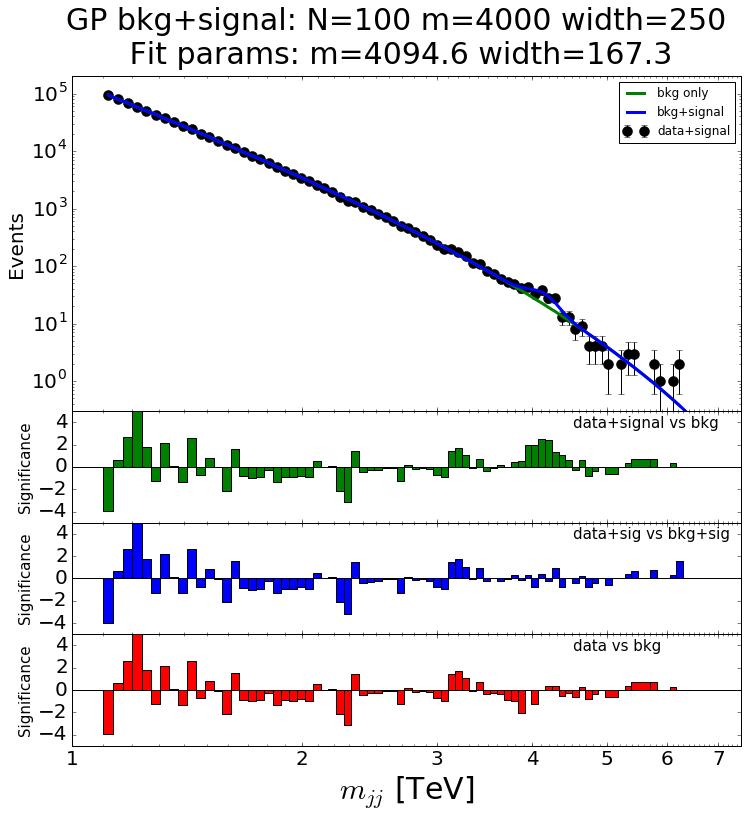

chi2 237.430084075


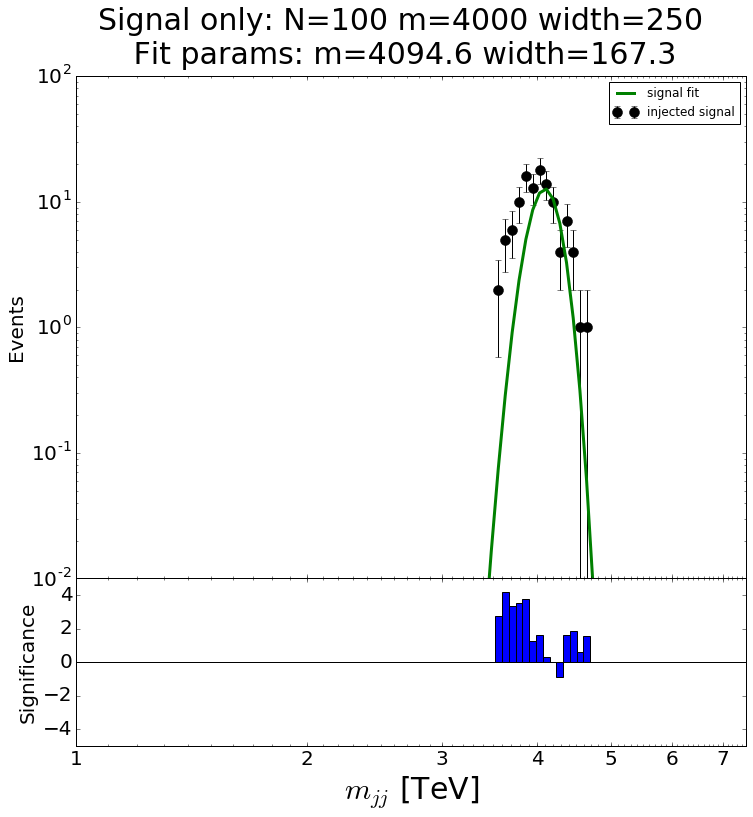

A, mass, tau 134.780935106 3926.93408715 397.982435038
A, mass, tau 482.380885361 3962.13297961 100.000981514
A, mass, tau 253.034312786 4032.97047296 203.181304281
A, mass, tau 239.559963171 4042.05752638 208.395848858
A, mass, tau 310.407114448 4023.50066431 221.948914686
A, mass, tau 137.572301705 4052.75009942 260.527147992
A, mass, tau 5728.85166853 1953.08040849 359.951497868
A, mass, tau 192.579019925 3919.56654183 370.048683119
A, mass, tau 467.161990699 4061.65384096 144.418668781
parameters (75, 4500, 250)
0
A, mass, tau 113.293815341 4473.33750806 194.243377625
chi2 bkg+signal mu=0 221.095052733
chi2 bkg+signal 152.457512963
73 73
chi2 bkg+signal 141.284725065


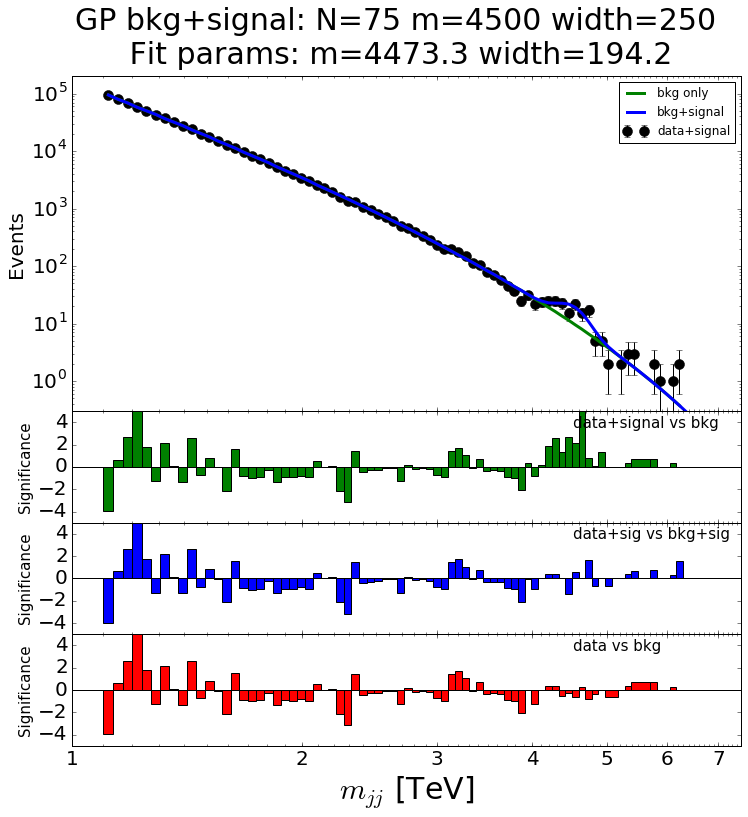

chi2 74.4635065845


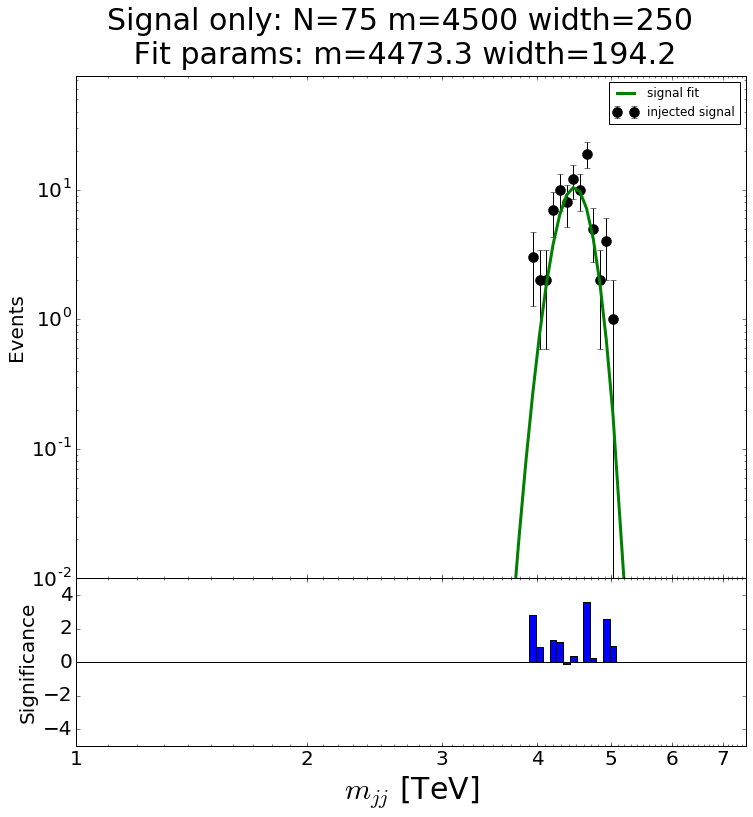

A, mass, tau 57.2143440531 4501.41855635 300.640751302
A, mass, tau 173.722051558 4605.5618552 160.89595525
A, mass, tau 115.474578426 4509.92220663 204.78578964
A, mass, tau 53.7392073718 4417.95758605 296.268400374
A, mass, tau 140.325645555 4341.09893357 271.694388463
A, mass, tau 133.244437836 4477.2277608 217.522884656
A, mass, tau 398.153747035 4478.13922793 129.444305899
A, mass, tau 149.691560046 4485.85987882 258.803255131
A, mass, tau 76.8644597254 4432.92887777 336.296458258
parameters (50, 5000, 250)
0
A, mass, tau 75.514630341 5034.15146698 246.20970177
chi2 bkg+signal mu=0 221.398428679
chi2 bkg+signal 152.468962742
73 73
chi2 bkg+signal 141.284725065


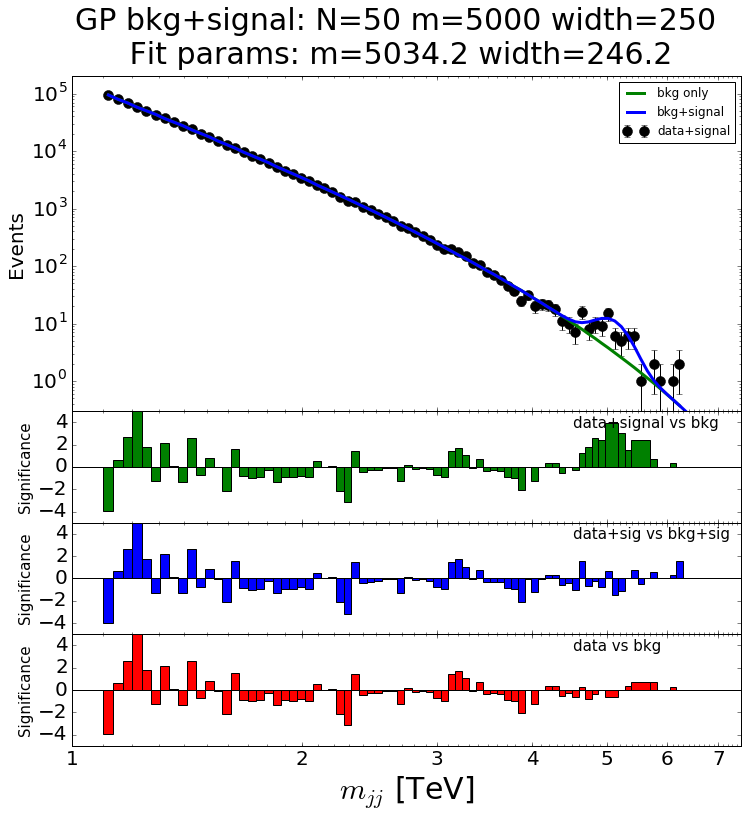

chi2 9.18913838648


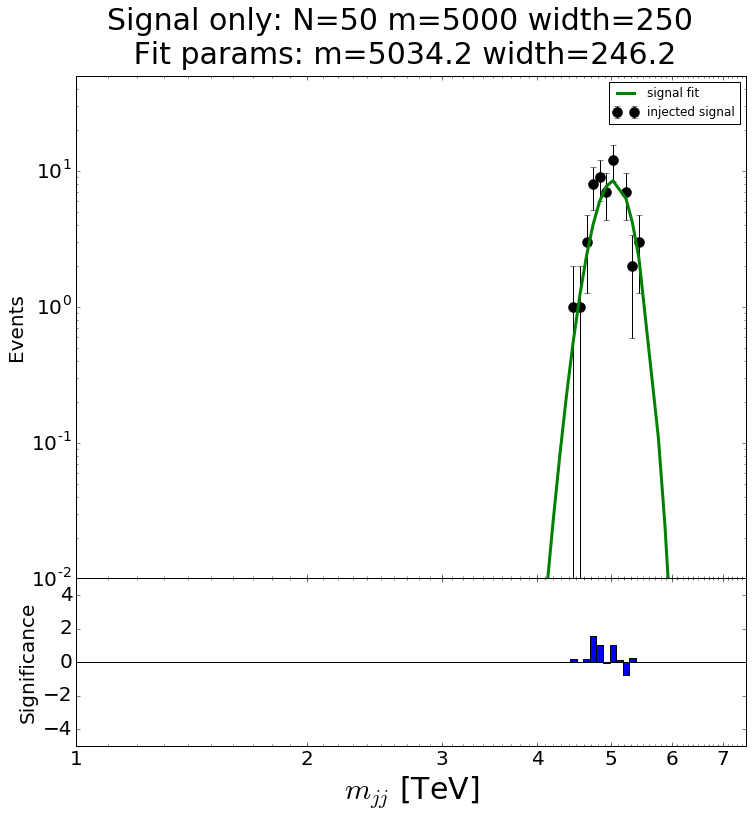

A, mass, tau 79.4831973563 5012.98371308 229.860805858
A, mass, tau 40.7903733651 5010.98119923 281.128285824
A, mass, tau 32.0317824637 5045.0892294 266.11908433
A, mass, tau 53.9756053663 4986.77396481 199.076203835
A, mass, tau 30.4154781896 5138.56160181 245.181643564
A, mass, tau 99999.9999999 1201.24622017 100.0


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in double_scalars
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars


A, mass, tau 49.5607145625 5013.36036775 362.917889323
A, mass, tau 16.9176585045 4904.65679012 499.976907835
A, mass, tau 79.6246679901 5078.53010574 205.964506472
parameters (40, 5500, 250)
0
A, mass, tau 110.74027916 5520.01688593 165.404705851
chi2 bkg+signal mu=0 270.788122844
chi2 bkg+signal 157.196997945
73 73
chi2 bkg+signal 141.284725065


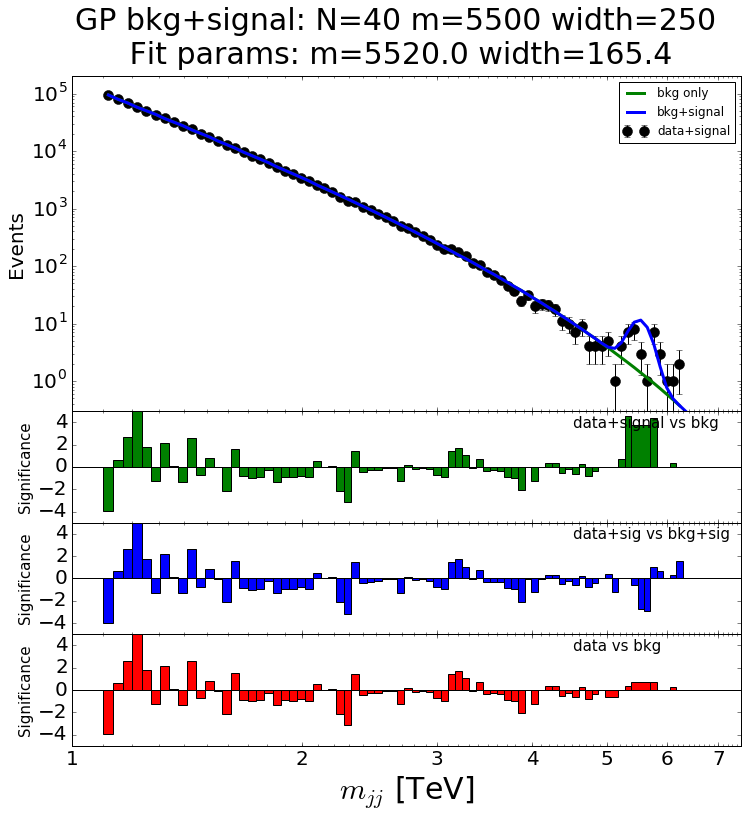

chi2 37.6514915971


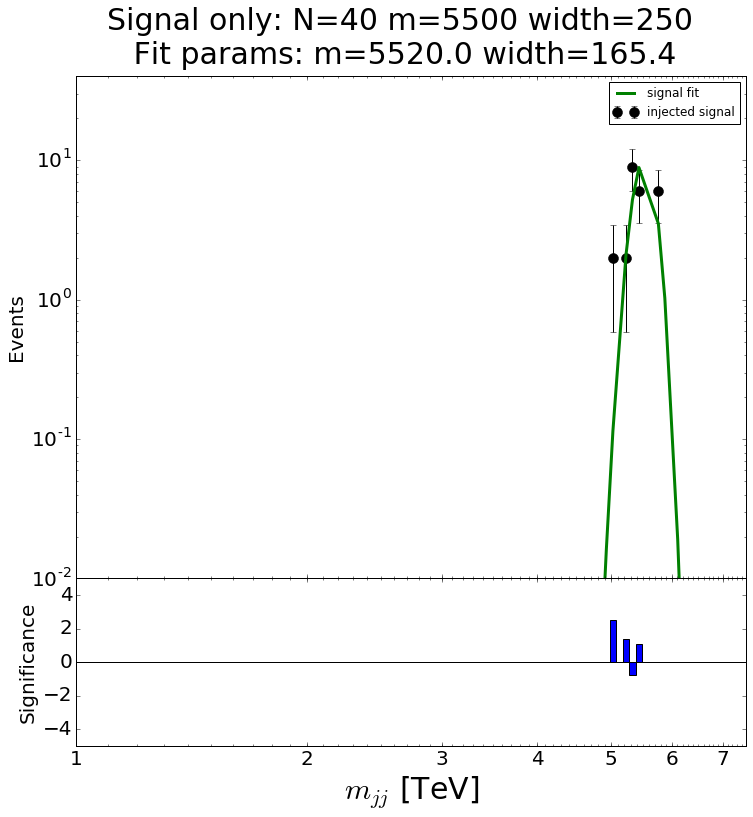

A, mass, tau 97.2253685967 5408.71691531 136.909030111
A, mass, tau 2180.96955179 2107.68102771 436.50524342
A, mass, tau 87.5297775572 5519.99223238 200.591780738
A, mass, tau 36.7581155388 5649.32829509 289.995256435
A, mass, tau 47.7212561432 5729.0342657 334.143623004
A, mass, tau 100000.0 1201.24638605 100.0
A, mass, tau 97.9646391636 5517.97964805 211.81092497
A, mass, tau 56.3828872766 5521.50062153 265.733105677
A, mass, tau 99999.9949357 1270.99779497 100.000000039
parameters (30, 6000, 250)
0
A, mass, tau 35.9339682023 5939.68011646 259.920268539
chi2 bkg+signal mu=0 299.923796884
chi2 bkg+signal 160.215805767
73 73
chi2 bkg+signal 141.284725065


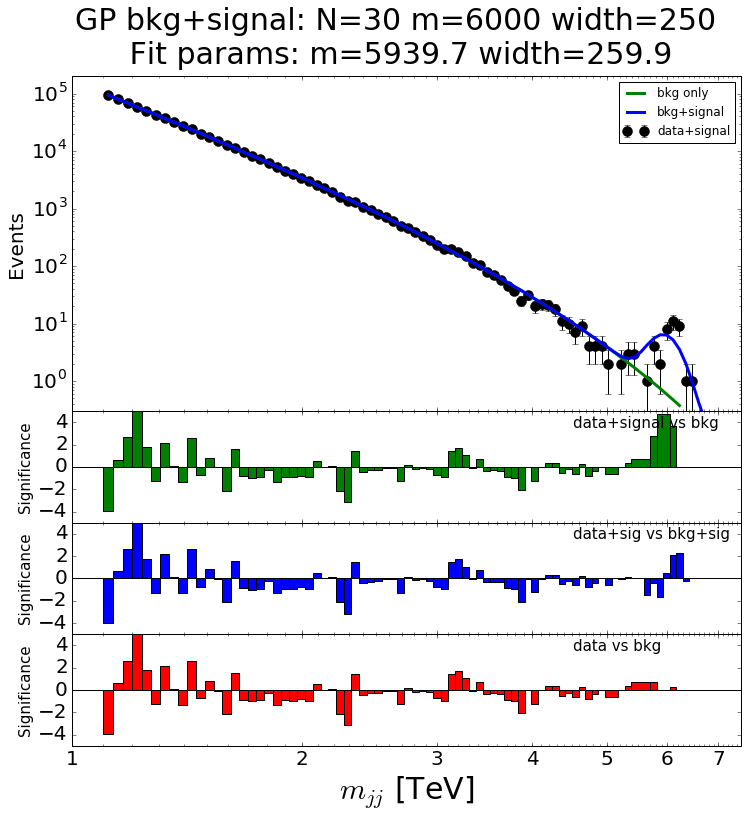

chi2 2.83620379142


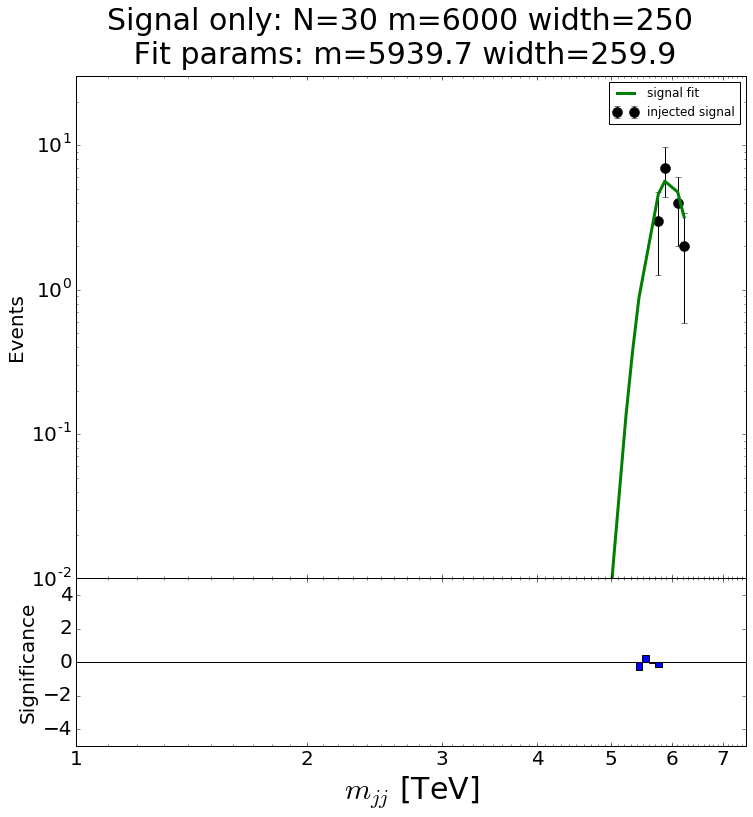

A, mass, tau 67.9348507168 6016.20918232 199.408141729
A, mass, tau 2180.43725484 2107.67690886 436.515845602
A, mass, tau 26999.6837679 1749.93671392 100.000000004
A, mass, tau 50.3941982998 5944.44431159 107.141943556
A, mass, tau 93383.4833658 1256.14897166 100.000000022
A, mass, tau 47.338786717 6084.87025701 280.847224007
A, mass, tau 5725.35021876 1953.01499135 360.165459573
A, mass, tau 23.3649010108 6126.93011201 410.278439142
A, mass, tau 99999.9929636 1270.99753159 100.000000051


In [31]:
chi_GP_sig={}
chi_GP_bkg={}
chi_GP_sb={}
aa={}
mm={}
ww={}
#standardParamSets = [(75, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    chi_GP_sig[m]=[]
    chi_GP_bkg[m]=[]
    chi_GP_sb[m]=[]
    aa[m]=[]
    mm[m]=[]
    ww[m]=[]
    for itoy, toy in enumerate(toyList[:10]):
        if itoy%100 ==0: print itoy
        
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        
        signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
        signalTemplate = np.random.poisson(np.around(signalTemplate))
        
        signalTemplateO = sig_model(xvalO, n, m, w, xerrO)
        signalTemplateO = np.random.poisson(np.around(signalTemplateO))

        #signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        #signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_3param(xtoy, (p0,p1, p2), xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

    
        zvalsig, chi2sig = calcSignificance(signalTemplate, mu2)
        zvalsb, chi2sb = calcSignificance(ydataO, meanGP)
        zvalbkg, chi2bkg = calcSignificance(ytoy, mu1)
        chi_GP_sig[m].append(chi2sig) 
        chi_GP_sb[m].append(chi2sb) 
        chi_GP_bkg[m].append(chi2bkg) 
        

        if itoy%10 ==0:
            label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
            makePrettyPlots_sb(xvalO, xtoy, ydataO, ydata, ytoy, mu1, meanGP, xtoylow, label)
    
    
            label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
            makePrettyPlots_signalOnly(xtoy, signalTemplate, mu2, label, n)
        

In [13]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

parameters (2000, 2000, 250)
15062.9628131 2097.49238391 164.609230432
parameters (700, 2500, 250)
12720.6267573 2448.20105847 185.124629773
parameters (250, 3000, 250)
11736.7726375 2707.79045476 197.635942505
parameters (125, 3500, 250)
3374.50373283 3213.68995676 212.702980173
parameters (70, 4000, 250)
22558.5054546 2824.32224527 222.296639208
parameters (40, 4500, 250)
33635.6104817 2505.21791509 232.325475208
parameters (25, 5000, 250)
44758.9004155 1680.26617214 233.372720795
parameters (15, 5500, 250)
44755.892015 1680.2659511 233.373503437
parameters (10, 6000, 250)
44746.8293942 1680.29325639 233.363549558


In [24]:
class logLike_gp_fitgpsig2:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, A1, w1):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            #print "hi", model_gp((p0,p1,p2), self.x, self.xerr)
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr) - sig_model(self.x, A1, mass, w1, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit2(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0)
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 500.
        #init4 = np.random.random() * 4000.
        init4 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  A = init0, mass = init1, tau = init2, A1 = init3, w1 = init4,
                  error_A = 100., error_mass = 10., error_tau = 5., error_A1 = 100., error_w1 = 5.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_A1 = (1, 1e5), 
                  limit_w1 = (100, 500))
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [27]:
chi_GP_sig2={}
chi_GP_bkg2={}
chi_GP_sb2={}
aa2={}
mm2={}
ww2={}
print fixedHyperparams
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    chi_GP_sig2[m]=[]
    chi_GP_bkg2[m]=[]
    chi_GP_sb2[m]=[]
    aa2[m]=[]
    mm2[m]=[]
    ww2[m]=[]
    for itoy, toy in enumerate(toyList[:10]):
        if itoy%10 ==0: print itoy
        
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig2(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit2(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        
        A, mass, tau, A1, w1 = best_fit_new 
        print "A, mass, tau", A, mass, tau, A1, w1

        #A, mass, tau = best_fit_new 
        aa2[m].append(A1)
        mm2[m].append(mass)
        ww2[m].append(w1)
        #print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr)-sig_model(xtoy, A1, mass, w1, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO) + sig_model(xvalO, A1, mass, w1, xerrO)
      #  meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
      #  meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_3param(xtoy, (p0,p1, p2), xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + sig_model(xtoy, A1, mass, w1, xtoyerr)

    
        zvalsig, chi2sig = calcSignificance(signalTemplate, mu2)
        zvalsb, chi2sb = calcSignificance(ydataO, meanGP)
        zvalbkg, chi2bkg = calcSignificance(ytoy, mu1)
        chi_GP_sig2[m].append(chi2sig) 
        chi_GP_sb2[m].append(chi2sb) 
        chi_GP_bkg2[m].append(chi2bkg) 
        


   # label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_sb(xvalO, xtoy, ydataO, ydata, ytoy, mu1, meanGP, xtoylow, label)
    
   # label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_signalOnly(xtoy, signalTemplate, mu2, label, n)
        

[  2.58152631e+07   1.62331670e+02   1.19749544e-01  -1.33472298e+02
   2.18750064e+00   1.64801807e-02   8.44386637e+00  -5.22509390e+00]
parameters (1500, 2000, 250)
0
A, mass, tau 1.00090878371 1988.45718149 100.000024697 1634.10945274 253.731937409
A, mass, tau 50303.4525291 1593.87411256 100.000000179 4209.10911978 499.993989451
A, mass, tau 1.00091743088 2047.77756049 100.020045651 1213.19931281 203.919584924
A, mass, tau 1.00004979832 2026.68332841 100.000455446 1356.67265781 239.441520969
A, mass, tau 1.00006519083 1895.56180215 100.005452364 1488.49427981 337.858300352
A, mass, tau 1.000001932 1968.18493395 100.007557528 1340.01627163 216.599273934
A, mass, tau 10790.0162786 1638.33164846 100.000056197 3406.33638371 437.227491555
A, mass, tau 1.00009011098 2055.78535213 100.008295124 1650.7583481 305.805112938
A, mass, tau 1.00142943873 1966.3205371 100.152592497 1702.09480434 225.269736721
A, mass, tau 1.00138765933 1995.09831468 100.012788165 1164.49825316 211.067547091
para

/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


A, mass, tau 1.00002276411 2618.26902745 100.00250653 258.592340343 452.85423442
A, mass, tau 1.00010139111 3778.93408658 100.000203568 50.6809556015 100.000011783
A, mass, tau 1.00000467154 3574.19132955 100.000037196 114.678219113 186.056641508
A, mass, tau 1.00000040267 3377.81141101 100.000216438 113.557744893 316.504723638
A, mass, tau 1360.77842625 3441.24943647 499.999985105 688.114118787 396.958258703
A, mass, tau 1.00019627011 3474.51362878 100.000002494 64.8480944742 102.167764114
A, mass, tau 1.0001079888 2434.21739423 100.001278853 240.203568589 205.963359872
A, mass, tau 1.00003598549 3232.28031428 100.000062131 106.063035612 281.503986765
A, mass, tau 1958.3858696 1745.5827039 499.998984333 532.471040905 100.000003462
parameters (50, 4000, 250)
0
A, mass, tau 1.00002760904 4096.21626334 100.023697396 16.7175138851 100.000001093
A, mass, tau 1.33648841372 3956.29134183 499.999999896 35.2521251031 100.000000106
A, mass, tau 1.0000002426 4107.95153695 100.000029736 77.936383

/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


A, mass, tau 155.789900624 3960.95810575 225.972891981 57.1667237699 100.000002001
A, mass, tau 1.00001031274 4741.08031845 100.007025229 35.4526611387 200.830183144
A, mass, tau 1.00000233151 3659.15790126 100.00136 39.8413038647 100.0
A, mass, tau 1.0000004957 3230.08721664 100.000000013 53.9564518815 100.000000017
A, mass, tau 142.752380491 4110.88024769 196.53846877 57.3067508269 100.000018318
A, mass, tau 109.365660748 4074.74600018 100.000016601 58.7404058555 499.999999431
A, mass, tau 600.876279459 2475.5796764 499.999472232 577.643436316 259.920006308
A, mass, tau 1.00000192077 5272.39753236 100.000141979 12.0886303587 187.171613664
A, mass, tau 118.111414444 3208.56203699 499.998877476 93.4595982282 161.925369289
parameters (15, 5500, 250)
0
A, mass, tau 1.00000216193 1337.71414717 100.000030883 809.708946224 100.000000011
A, mass, tau 131.30314674 3959.5669316 240.790457007 53.4255500848 100.00005148
A, mass, tau 99998.837546 1339.30349384 170.68059858 4133.89935126 100.00000

In [28]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa2[m]), np.mean(mm2[m]), np.mean(ww2[m])
    

parameters (1500, 2000, 250)
1916.52888839 1917.60747714 293.091449534
parameters (750, 2500, 250)
769.653754224 2524.47075355 246.475853018
parameters (200, 3000, 250)
357.355470772 2845.91100675 307.581111732
parameters (75, 3500, 250)
297.881451815 2901.48093903 224.200898945
parameters (50, 4000, 250)
49.5113594749 4063.58365707 175.565756677
parameters (25, 4500, 250)
110.563799713 3793.70488762 216.042547247
parameters (20, 5000, 250)
179.51870516 3607.12150992 180.984719248
parameters (15, 5500, 250)
581.396247138 3408.33750967 171.490459283
parameters (15, 6000, 250)
75.9248766538 4927.76586104 247.140230774


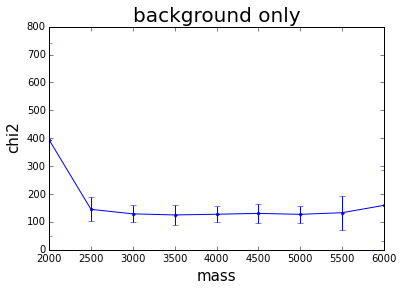

In [47]:

plt.title("background only", fontsize=20)
plt.errorbar(msignals,[chi_GP_bkg[i][0] for i in range(len(chi_GP_bkg))],yerr = [chi_GP_bkg[i][2] for i in range(len(chi_GP_bkg))], marker=".", linestyle="-")
plt.xlabel('mass', fontsize=15)
plt.ylabel('chi2', fontsize=15)
#plt.set_xscale('log')
#plt.set_yscale('log')


#plt.errorbar([1900, 2400, 2800, 3300, 3800, 4300, 4700, 5300],[chi_GP_sig[i][0] for i in range(len(chi_GP_sig)-1)],yerr = [chi_GP_sig[i][2] for i in range(len(chi_GP_sig)-1)], marker=".", linestyle="-")
#plt.xlabel('mass', fontsize=15)
#plt.ylabel('chi2', fontsize=15)

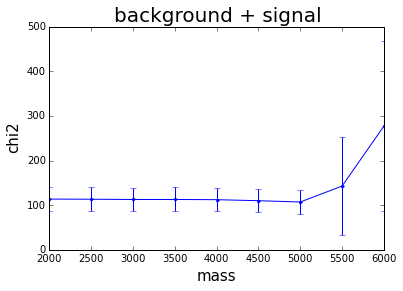

In [48]:
plt.title("background + signal", fontsize=20)
plt.errorbar(msignals,[chi_GP_sb[i][0] for i in range(len(chi_GP_sb))],yerr = [chi_GP_sb[i][2] for i in range(len(chi_GP_sb))], marker=".", linestyle="-")
plt.xlabel('mass', fontsize=15)
plt.ylabel('chi2', fontsize=15)